## 클래스별 파일 개수

In [10]:
import os
from collections import Counter
from pathlib import Path
import pandas as pd  # 테이블 보기 편함

root_dir = Path('./files/2_Animal_emotions')
jpg_counts = Counter()

# 1_Animal_Behavior 바로 아래 폴더만 대상
for subdir in root_dir.iterdir():
    if subdir.is_dir():
        jpg_count = len(list(subdir.rglob('*.jpg')))
        jpg_counts[subdir.name] = jpg_count

# 테이블 출력
df = pd.DataFrame.from_dict(jpg_counts, orient='index', columns=['JPG Count']).sort_values('JPG Count', ascending=False)
print(df)


               JPG Count
dog_happy          17355
dog_sad            14206
dog_anxious        11590
dog_relaxed         8699
dog_angry           8564
dog_confused        3286
cat_relaxed         2999
cat_happy           1221
cat_attentive        997
cat_sad              171


## train

/opt/conda/envs/cap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🎯 Device: cuda:1

📦 Collecting behavior...
  → 757113 samples, 25 classes
  🎯 Target: 100000 samples
  📊 25 classes → max 4000 per class
    CAT_ARCH: 2296/2296
    CAT_ARMSTRETCH: 4000/38483
    CAT_FOOTPUSH: 4000/9517
    CAT_GETDOWN: 4000/13421
    CAT_GROOMING: 4000/65029
    CAT_HEADING: 4000/11237
    CAT_LAYDOWN: 4000/21474
    CAT_LYING: 4000/12119
    CAT_ROLL: 4000/8513
    CAT_SITDOWN: 4000/18401
    CAT_TAILING: 4000/36960
    CAT_WALKRUN: 4000/30498
    DOG_BODYLOWER: 4000/79772
    DOG_BODYSCRATCH: 4000/15783
    DOG_BODYSHAKE: 4000/15296
    DOG_FEETUP: 4000/34365
    DOG_FOOTUP: 4000/52506
    DOG_HEADING: 4000/19052
    DOG_LYING: 4000/32129
    DOG_MOUNTING: 4000/5211
    DOG_SIT: 4000/79182
    DOG_TAILING: 4000/35824
    DOG_TAILLOW: 4000/8376
    DOG_TURN: 4000/21554
    DOG_WALKRUN: 4000/90115
  ✅ Total sampled: 98296

📦 Collecting emotion...
  → 69113 samples, 10 classes
  🎯 Target: 100000 samples
  📊 10 classes → max 10000 per class
    cat_attentive: 997/997
  


✅ Dataset ready

🔄 Loading datasets...
  📊 behavior: 11864 samples, 25 classes
  📊 behavior: 5301 samples, 25 classes
  📊 emotion: 44766 samples, 10 classes
  📊 emotion: 5592 samples, 10 classes
  📊 sound: 995 samples, 16 classes
  📊 sound: 121 samples, 16 classes

📦 DataLoaders:
  Behavior: 742 train batches, 332 val batches
  Emotion: 2798 train batches, 350 val batches
  Sound: 63 train batches, 8 val batches


Loading weights: 100%|██████████| 211/211 [00:00<00:00, 482.28it/s, Materializing param=wav2vec2.masked_spec_embed]                                            
Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
project_q.weight             | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
quantizer.weight_proj.bias   | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
projector.bias               | MISSING    | 
classifier.bias              | MISSING    | 
projector.weight             | MISSING    | 
classifier.weight            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because miss


Epoch 1/50

🐾 Training Behavior...


  → Avg Loss: 1.9263

😊 Training Emotion...


  → Avg Loss: 0.7788

🔊 Training Sound...


  → Avg Loss: 1.5646

🔍 Validation...



📊 Results:
  Behavior: Loss 1.9263 | Acc 0.4886 (48.9%)
  Emotion:  Loss 0.7788 | Acc 0.6645 (66.5%)
  Sound:    Loss 1.5646 | Acc 0.2562 (25.6%)
  Average Acc: 0.4698 (47.0%)
  💾 Saved new best model! (Acc: 0.4698)

Epoch 2/50

🐾 Training Behavior...


  → Avg Loss: 1.1526

😊 Training Emotion...


  → Avg Loss: 0.6564

🔊 Training Sound...


  → Avg Loss: 1.3772

🔍 Validation...



📊 Results:
  Behavior: Loss 1.1526 | Acc 0.5757 (57.6%)
  Emotion:  Loss 0.6564 | Acc 0.6744 (67.4%)
  Sound:    Loss 1.3772 | Acc 0.3884 (38.8%)
  Average Acc: 0.5462 (54.6%)
  💾 Saved new best model! (Acc: 0.5462)

Epoch 3/50

🐾 Training Behavior...


  → Avg Loss: 0.8139

😊 Training Emotion...


  → Avg Loss: 0.5916

🔊 Training Sound...


  → Avg Loss: 1.2338

🔍 Validation...



📊 Results:
  Behavior: Loss 0.8139 | Acc 0.6180 (61.8%)
  Emotion:  Loss 0.5916 | Acc 0.6774 (67.7%)
  Sound:    Loss 1.2338 | Acc 0.6198 (62.0%)
  Average Acc: 0.6384 (63.8%)
  💾 Saved new best model! (Acc: 0.6384)

Epoch 4/50

🐾 Training Behavior...


  → Avg Loss: 0.5734

😊 Training Emotion...


  → Avg Loss: 0.5413

🔊 Training Sound...


  → Avg Loss: 1.1018

🔍 Validation...



📊 Results:
  Behavior: Loss 0.5734 | Acc 0.6337 (63.4%)
  Emotion:  Loss 0.5413 | Acc 0.6831 (68.3%)
  Sound:    Loss 1.1018 | Acc 0.5289 (52.9%)
  Average Acc: 0.6152 (61.5%)

Epoch 5/50

🐾 Training Behavior...


  → Avg Loss: 0.4501

😊 Training Emotion...


  → Avg Loss: 0.4972

🔊 Training Sound...


  → Avg Loss: 1.0045

🔍 Validation...



📊 Results:
  Behavior: Loss 0.4501 | Acc 0.6403 (64.0%)
  Emotion:  Loss 0.4972 | Acc 0.7055 (70.5%)
  Sound:    Loss 1.0045 | Acc 0.5455 (54.5%)
  Average Acc: 0.6304 (63.0%)

Epoch 6/50

🐾 Training Behavior...


  → Avg Loss: 0.3503

😊 Training Emotion...


  → Avg Loss: 0.4590

🔊 Training Sound...


  → Avg Loss: 0.9120

🔍 Validation...



📊 Results:
  Behavior: Loss 0.3503 | Acc 0.6465 (64.6%)
  Emotion:  Loss 0.4590 | Acc 0.7135 (71.4%)
  Sound:    Loss 0.9120 | Acc 0.6198 (62.0%)
  Average Acc: 0.6599 (66.0%)
  💾 Saved new best model! (Acc: 0.6599)

Epoch 7/50

🐾 Training Behavior...


  → Avg Loss: 0.2798

😊 Training Emotion...


  → Avg Loss: 0.4282

🔊 Training Sound...


  → Avg Loss: 0.8226

🔍 Validation...



📊 Results:
  Behavior: Loss 0.2798 | Acc 0.6555 (65.6%)
  Emotion:  Loss 0.4282 | Acc 0.7142 (71.4%)
  Sound:    Loss 0.8226 | Acc 0.6529 (65.3%)
  Average Acc: 0.6742 (67.4%)
  💾 Saved new best model! (Acc: 0.6742)

Epoch 8/50

🐾 Training Behavior...


  → Avg Loss: 0.2686

😊 Training Emotion...


  → Avg Loss: 0.3982

🔊 Training Sound...


  → Avg Loss: 0.7464

🔍 Validation...



📊 Results:
  Behavior: Loss 0.2686 | Acc 0.6489 (64.9%)
  Emotion:  Loss 0.3982 | Acc 0.7225 (72.2%)
  Sound:    Loss 0.7464 | Acc 0.6116 (61.2%)
  Average Acc: 0.6610 (66.1%)

Epoch 9/50

🐾 Training Behavior...


  → Avg Loss: 0.2121

😊 Training Emotion...


  → Avg Loss: 0.3757

🔊 Training Sound...


  → Avg Loss: 0.6934

🔍 Validation...



📊 Results:
  Behavior: Loss 0.2121 | Acc 0.6520 (65.2%)
  Emotion:  Loss 0.3757 | Acc 0.7255 (72.6%)
  Sound:    Loss 0.6934 | Acc 0.6942 (69.4%)
  Average Acc: 0.6906 (69.1%)
  💾 Saved new best model! (Acc: 0.6906)

Epoch 10/50

🐾 Training Behavior...


  → Avg Loss: 0.2010

😊 Training Emotion...


  → Avg Loss: 0.3568

🔊 Training Sound...


  → Avg Loss: 0.6165

🔍 Validation...



📊 Results:
  Behavior: Loss 0.2010 | Acc 0.6557 (65.6%)
  Emotion:  Loss 0.3568 | Acc 0.7396 (74.0%)
  Sound:    Loss 0.6165 | Acc 0.6612 (66.1%)
  Average Acc: 0.6855 (68.6%)

Epoch 11/50

🐾 Training Behavior...


  → Avg Loss: 0.1881

😊 Training Emotion...


  → Avg Loss: 0.3405

🔊 Training Sound...


  → Avg Loss: 0.5831

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1881 | Acc 0.6557 (65.6%)
  Emotion:  Loss 0.3405 | Acc 0.7257 (72.6%)
  Sound:    Loss 0.5831 | Acc 0.6529 (65.3%)
  Average Acc: 0.6781 (67.8%)

Epoch 12/50

🐾 Training Behavior...


  → Avg Loss: 0.1842

😊 Training Emotion...


  → Avg Loss: 0.3270

🔊 Training Sound...


  → Avg Loss: 0.5330

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1842 | Acc 0.6661 (66.6%)
  Emotion:  Loss 0.3270 | Acc 0.7411 (74.1%)
  Sound:    Loss 0.5330 | Acc 0.5950 (59.5%)
  Average Acc: 0.6674 (66.7%)

Epoch 13/50

🐾 Training Behavior...


  → Avg Loss: 0.1506

😊 Training Emotion...


  → Avg Loss: 0.3117

🔊 Training Sound...


  → Avg Loss: 0.5769

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1506 | Acc 0.6721 (67.2%)
  Emotion:  Loss 0.3117 | Acc 0.7318 (73.2%)
  Sound:    Loss 0.5769 | Acc 0.6860 (68.6%)
  Average Acc: 0.6966 (69.7%)
  💾 Saved new best model! (Acc: 0.6966)

Epoch 14/50

🐾 Training Behavior...


  → Avg Loss: 0.1560

😊 Training Emotion...


  → Avg Loss: 0.2998

🔊 Training Sound...


  → Avg Loss: 0.4743

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1560 | Acc 0.6778 (67.8%)
  Emotion:  Loss 0.2998 | Acc 0.7445 (74.4%)
  Sound:    Loss 0.4743 | Acc 0.6860 (68.6%)
  Average Acc: 0.7027 (70.3%)
  💾 Saved new best model! (Acc: 0.7027)

Epoch 15/50

🐾 Training Behavior...


  → Avg Loss: 0.1430

😊 Training Emotion...


  → Avg Loss: 0.2919

🔊 Training Sound...


  → Avg Loss: 0.4304

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1430 | Acc 0.6759 (67.6%)
  Emotion:  Loss 0.2919 | Acc 0.7234 (72.3%)
  Sound:    Loss 0.4304 | Acc 0.7025 (70.2%)
  Average Acc: 0.7006 (70.1%)

Epoch 16/50

🐾 Training Behavior...


  → Avg Loss: 0.1328

😊 Training Emotion...


  → Avg Loss: 0.2834

🔊 Training Sound...


  → Avg Loss: 0.4362

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1328 | Acc 0.6718 (67.2%)
  Emotion:  Loss 0.2834 | Acc 0.7484 (74.8%)
  Sound:    Loss 0.4362 | Acc 0.6281 (62.8%)
  Average Acc: 0.6827 (68.3%)

Epoch 17/50

🐾 Training Behavior...


  → Avg Loss: 0.1329

😊 Training Emotion...


  → Avg Loss: 0.2746

🔊 Training Sound...


  → Avg Loss: 0.3952

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1329 | Acc 0.6806 (68.1%)
  Emotion:  Loss 0.2746 | Acc 0.7455 (74.6%)
  Sound:    Loss 0.3952 | Acc 0.6860 (68.6%)
  Average Acc: 0.7040 (70.4%)
  💾 Saved new best model! (Acc: 0.7040)

Epoch 18/50

🐾 Training Behavior...


  → Avg Loss: 0.1357

😊 Training Emotion...


  → Avg Loss: 0.2710

🔊 Training Sound...


  → Avg Loss: 0.3431

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1357 | Acc 0.6667 (66.7%)
  Emotion:  Loss 0.2710 | Acc 0.7420 (74.2%)
  Sound:    Loss 0.3431 | Acc 0.7273 (72.7%)
  Average Acc: 0.7120 (71.2%)
  💾 Saved new best model! (Acc: 0.7120)

Epoch 19/50

🐾 Training Behavior...


  → Avg Loss: 0.1307

😊 Training Emotion...


  → Avg Loss: 0.2642

🔊 Training Sound...


  → Avg Loss: 0.3238

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1307 | Acc 0.6763 (67.6%)
  Emotion:  Loss 0.2642 | Acc 0.7493 (74.9%)
  Sound:    Loss 0.3238 | Acc 0.7273 (72.7%)
  Average Acc: 0.7176 (71.8%)
  💾 Saved new best model! (Acc: 0.7176)

Epoch 20/50

🐾 Training Behavior...


  → Avg Loss: 0.1103

😊 Training Emotion...


  → Avg Loss: 0.2571

🔊 Training Sound...


  → Avg Loss: 0.3098

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1103 | Acc 0.6806 (68.1%)
  Emotion:  Loss 0.2571 | Acc 0.7539 (75.4%)
  Sound:    Loss 0.3098 | Acc 0.7190 (71.9%)
  Average Acc: 0.7179 (71.8%)
  💾 Saved new best model! (Acc: 0.7179)

Epoch 21/50

🐾 Training Behavior...


  → Avg Loss: 0.1028

😊 Training Emotion...


  → Avg Loss: 0.2542

🔊 Training Sound...


  → Avg Loss: 0.2996

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1028 | Acc 0.6772 (67.7%)
  Emotion:  Loss 0.2542 | Acc 0.7416 (74.2%)
  Sound:    Loss 0.2996 | Acc 0.7107 (71.1%)
  Average Acc: 0.7099 (71.0%)

Epoch 22/50

🐾 Training Behavior...


  → Avg Loss: 0.1155

😊 Training Emotion...


  → Avg Loss: 0.2507

🔊 Training Sound...


  → Avg Loss: 0.2613

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1155 | Acc 0.6787 (67.9%)
  Emotion:  Loss 0.2507 | Acc 0.7368 (73.7%)
  Sound:    Loss 0.2613 | Acc 0.7273 (72.7%)
  Average Acc: 0.7143 (71.4%)

Epoch 23/50

🐾 Training Behavior...


  → Avg Loss: 0.0950

😊 Training Emotion...


  → Avg Loss: 0.2443

🔊 Training Sound...


  → Avg Loss: 0.2489

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0950 | Acc 0.6910 (69.1%)
  Emotion:  Loss 0.2443 | Acc 0.7420 (74.2%)
  Sound:    Loss 0.2489 | Acc 0.7107 (71.1%)
  Average Acc: 0.7146 (71.5%)

Epoch 24/50

🐾 Training Behavior...


  → Avg Loss: 0.0905

😊 Training Emotion...


  → Avg Loss: 0.2395

🔊 Training Sound...


  → Avg Loss: 0.2499

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0905 | Acc 0.6869 (68.7%)
  Emotion:  Loss 0.2395 | Acc 0.7280 (72.8%)
  Sound:    Loss 0.2499 | Acc 0.7273 (72.7%)
  Average Acc: 0.7140 (71.4%)

Epoch 25/50

🐾 Training Behavior...


  → Avg Loss: 0.1093

😊 Training Emotion...


  → Avg Loss: 0.2393

🔊 Training Sound...


  → Avg Loss: 0.2435

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1093 | Acc 0.6765 (67.6%)
  Emotion:  Loss 0.2393 | Acc 0.7434 (74.3%)
  Sound:    Loss 0.2435 | Acc 0.7521 (75.2%)
  Average Acc: 0.7240 (72.4%)
  💾 Saved new best model! (Acc: 0.7240)

Epoch 26/50

🐾 Training Behavior...


  → Avg Loss: 0.0844

😊 Training Emotion...


  → Avg Loss: 0.2323

🔊 Training Sound...


  → Avg Loss: 0.2666

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0844 | Acc 0.6899 (69.0%)
  Emotion:  Loss 0.2323 | Acc 0.7402 (74.0%)
  Sound:    Loss 0.2666 | Acc 0.7025 (70.2%)
  Average Acc: 0.7108 (71.1%)

Epoch 27/50

🐾 Training Behavior...


  → Avg Loss: 0.1071

😊 Training Emotion...


  → Avg Loss: 0.2322

🔊 Training Sound...


  → Avg Loss: 0.2336

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1071 | Acc 0.6833 (68.3%)
  Emotion:  Loss 0.2322 | Acc 0.7482 (74.8%)
  Sound:    Loss 0.2336 | Acc 0.6942 (69.4%)
  Average Acc: 0.7086 (70.9%)

Epoch 28/50

🐾 Training Behavior...


  → Avg Loss: 0.0904

😊 Training Emotion...


  → Avg Loss: 0.2289

🔊 Training Sound...


  → Avg Loss: 0.2330

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0904 | Acc 0.6838 (68.4%)
  Emotion:  Loss 0.2289 | Acc 0.7475 (74.7%)
  Sound:    Loss 0.2330 | Acc 0.7355 (73.6%)
  Average Acc: 0.7223 (72.2%)

Epoch 29/50

🐾 Training Behavior...


  → Avg Loss: 0.0919

😊 Training Emotion...


  → Avg Loss: 0.2220

🔊 Training Sound...


  → Avg Loss: 0.1933

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0919 | Acc 0.6789 (67.9%)
  Emotion:  Loss 0.2220 | Acc 0.7439 (74.4%)
  Sound:    Loss 0.1933 | Acc 0.7190 (71.9%)
  Average Acc: 0.7140 (71.4%)

Epoch 30/50

🐾 Training Behavior...


  → Avg Loss: 0.0615

😊 Training Emotion...


  → Avg Loss: 0.2223

🔊 Training Sound...


  → Avg Loss: 0.1920

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0615 | Acc 0.6719 (67.2%)
  Emotion:  Loss 0.2223 | Acc 0.7323 (73.2%)
  Sound:    Loss 0.1920 | Acc 0.7438 (74.4%)
  Average Acc: 0.7160 (71.6%)

Epoch 31/50

🐾 Training Behavior...


  → Avg Loss: 0.0896

😊 Training Emotion...


  → Avg Loss: 0.2182

🔊 Training Sound...


  → Avg Loss: 0.1940

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0896 | Acc 0.6757 (67.6%)
  Emotion:  Loss 0.2182 | Acc 0.7579 (75.8%)
  Sound:    Loss 0.1940 | Acc 0.7273 (72.7%)
  Average Acc: 0.7203 (72.0%)

Epoch 32/50

🐾 Training Behavior...


  → Avg Loss: 0.0765

😊 Training Emotion...


  → Avg Loss: 0.2177

🔊 Training Sound...


  → Avg Loss: 0.1905

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0765 | Acc 0.6891 (68.9%)
  Emotion:  Loss 0.2177 | Acc 0.7364 (73.6%)
  Sound:    Loss 0.1905 | Acc 0.7190 (71.9%)
  Average Acc: 0.7148 (71.5%)

Epoch 33/50

🐾 Training Behavior...


  → Avg Loss: 0.0657

😊 Training Emotion...


  → Avg Loss: 0.2124

🔊 Training Sound...


  → Avg Loss: 0.1948

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0657 | Acc 0.6806 (68.1%)
  Emotion:  Loss 0.2124 | Acc 0.7457 (74.6%)
  Sound:    Loss 0.1948 | Acc 0.7025 (70.2%)
  Average Acc: 0.7096 (71.0%)

Epoch 34/50

🐾 Training Behavior...


  → Avg Loss: 0.1021

😊 Training Emotion...


  → Avg Loss: 0.2143

🔊 Training Sound...


  → Avg Loss: 0.1802

🔍 Validation...



📊 Results:
  Behavior: Loss 0.1021 | Acc 0.6904 (69.0%)
  Emotion:  Loss 0.2143 | Acc 0.7452 (74.5%)
  Sound:    Loss 0.1802 | Acc 0.7438 (74.4%)
  Average Acc: 0.7265 (72.6%)
  💾 Saved new best model! (Acc: 0.7265)

Epoch 35/50

🐾 Training Behavior...


  → Avg Loss: 0.0721

😊 Training Emotion...


  → Avg Loss: 0.2090

🔊 Training Sound...


  → Avg Loss: 0.1784

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0721 | Acc 0.6893 (68.9%)
  Emotion:  Loss 0.2090 | Acc 0.7362 (73.6%)
  Sound:    Loss 0.1784 | Acc 0.7273 (72.7%)
  Average Acc: 0.7176 (71.8%)

Epoch 36/50

🐾 Training Behavior...


  → Avg Loss: 0.0650

😊 Training Emotion...


  → Avg Loss: 0.2087

🔊 Training Sound...


  → Avg Loss: 0.1726

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0650 | Acc 0.6933 (69.3%)
  Emotion:  Loss 0.2087 | Acc 0.7468 (74.7%)
  Sound:    Loss 0.1726 | Acc 0.7355 (73.6%)
  Average Acc: 0.7252 (72.5%)

Epoch 37/50

🐾 Training Behavior...


  → Avg Loss: 0.0748

😊 Training Emotion...


  → Avg Loss: 0.2071

🔊 Training Sound...


  → Avg Loss: 0.1541

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0748 | Acc 0.6827 (68.3%)
  Emotion:  Loss 0.2071 | Acc 0.7500 (75.0%)
  Sound:    Loss 0.1541 | Acc 0.7438 (74.4%)
  Average Acc: 0.7255 (72.6%)

Epoch 38/50

🐾 Training Behavior...


  → Avg Loss: 0.0601

😊 Training Emotion...


  → Avg Loss: 0.2048

🔊 Training Sound...


  → Avg Loss: 0.1442

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0601 | Acc 0.6884 (68.8%)
  Emotion:  Loss 0.2048 | Acc 0.7253 (72.5%)
  Sound:    Loss 0.1442 | Acc 0.7355 (73.6%)
  Average Acc: 0.7164 (71.6%)

Epoch 39/50

🐾 Training Behavior...


  → Avg Loss: 0.0664

😊 Training Emotion...


  → Avg Loss: 0.2026

🔊 Training Sound...


  → Avg Loss: 0.1438

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0664 | Acc 0.6793 (67.9%)
  Emotion:  Loss 0.2026 | Acc 0.7457 (74.6%)
  Sound:    Loss 0.1438 | Acc 0.7107 (71.1%)
  Average Acc: 0.7119 (71.2%)

Epoch 40/50

🐾 Training Behavior...


  → Avg Loss: 0.0730

😊 Training Emotion...


  → Avg Loss: 0.2018

🔊 Training Sound...


  → Avg Loss: 0.1371

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0730 | Acc 0.6980 (69.8%)
  Emotion:  Loss 0.2018 | Acc 0.7400 (74.0%)
  Sound:    Loss 0.1371 | Acc 0.7273 (72.7%)
  Average Acc: 0.7217 (72.2%)

Epoch 41/50

🐾 Training Behavior...


  → Avg Loss: 0.0564

😊 Training Emotion...


  → Avg Loss: 0.1998

🔊 Training Sound...


  → Avg Loss: 0.1335

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0564 | Acc 0.6936 (69.4%)
  Emotion:  Loss 0.1998 | Acc 0.7434 (74.3%)
  Sound:    Loss 0.1335 | Acc 0.7190 (71.9%)
  Average Acc: 0.7187 (71.9%)

Epoch 42/50

🐾 Training Behavior...


  → Avg Loss: 0.0713

😊 Training Emotion...


  → Avg Loss: 0.1988

🔊 Training Sound...


  → Avg Loss: 0.1267

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0713 | Acc 0.6899 (69.0%)
  Emotion:  Loss 0.1988 | Acc 0.7505 (75.1%)
  Sound:    Loss 0.1267 | Acc 0.7273 (72.7%)
  Average Acc: 0.7226 (72.3%)

Epoch 43/50

🐾 Training Behavior...


  → Avg Loss: 0.0643

😊 Training Emotion...


  → Avg Loss: 0.1955

🔊 Training Sound...


  → Avg Loss: 0.1260

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0643 | Acc 0.6902 (69.0%)
  Emotion:  Loss 0.1955 | Acc 0.7530 (75.3%)
  Sound:    Loss 0.1260 | Acc 0.7438 (74.4%)
  Average Acc: 0.7290 (72.9%)
  💾 Saved new best model! (Acc: 0.7290)

Epoch 44/50

🐾 Training Behavior...


  → Avg Loss: 0.0616

😊 Training Emotion...


  → Avg Loss: 0.1957

🔊 Training Sound...


  → Avg Loss: 0.1226

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0616 | Acc 0.6825 (68.3%)
  Emotion:  Loss 0.1957 | Acc 0.7445 (74.4%)
  Sound:    Loss 0.1226 | Acc 0.7273 (72.7%)
  Average Acc: 0.7181 (71.8%)

Epoch 45/50

🐾 Training Behavior...


  → Avg Loss: 0.0531

😊 Training Emotion...


  → Avg Loss: 0.1927

🔊 Training Sound...


  → Avg Loss: 0.1250

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0531 | Acc 0.7068 (70.7%)
  Emotion:  Loss 0.1927 | Acc 0.7521 (75.2%)
  Sound:    Loss 0.1250 | Acc 0.7025 (70.2%)
  Average Acc: 0.7205 (72.0%)

Epoch 46/50

🐾 Training Behavior...


  → Avg Loss: 0.0644

😊 Training Emotion...


  → Avg Loss: 0.1894

🔊 Training Sound...


  → Avg Loss: 0.1205

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0644 | Acc 0.6831 (68.3%)
  Emotion:  Loss 0.1894 | Acc 0.7384 (73.8%)
  Sound:    Loss 0.1205 | Acc 0.7190 (71.9%)
  Average Acc: 0.7135 (71.3%)

Epoch 47/50

🐾 Training Behavior...


  → Avg Loss: 0.0632

😊 Training Emotion...


  → Avg Loss: 0.1909

🔊 Training Sound...


  → Avg Loss: 0.1156

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0632 | Acc 0.7027 (70.3%)
  Emotion:  Loss 0.1909 | Acc 0.7303 (73.0%)
  Sound:    Loss 0.1156 | Acc 0.6694 (66.9%)
  Average Acc: 0.7008 (70.1%)

Epoch 48/50

🐾 Training Behavior...


  → Avg Loss: 0.0417

😊 Training Emotion...


  → Avg Loss: 0.1880

🔊 Training Sound...


  → Avg Loss: 0.1170

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0417 | Acc 0.6957 (69.6%)
  Emotion:  Loss 0.1880 | Acc 0.7327 (73.3%)
  Sound:    Loss 0.1170 | Acc 0.7438 (74.4%)
  Average Acc: 0.7241 (72.4%)

Epoch 49/50

🐾 Training Behavior...


  → Avg Loss: 0.0560

😊 Training Emotion...


  → Avg Loss: 0.1869

🔊 Training Sound...


  → Avg Loss: 0.1090

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0560 | Acc 0.6961 (69.6%)
  Emotion:  Loss 0.1869 | Acc 0.7248 (72.5%)
  Sound:    Loss 0.1090 | Acc 0.7190 (71.9%)
  Average Acc: 0.7133 (71.3%)

Epoch 50/50

🐾 Training Behavior...


  → Avg Loss: 0.0543

😊 Training Emotion...


  → Avg Loss: 0.1886

🔊 Training Sound...


  → Avg Loss: 0.1132

🔍 Validation...



📊 Results:
  Behavior: Loss 0.0543 | Acc 0.6948 (69.5%)
  Emotion:  Loss 0.1886 | Acc 0.7328 (73.3%)
  Sound:    Loss 0.1132 | Acc 0.7190 (71.9%)
  Average Acc: 0.7155 (71.6%)

📈 Generating training history plot...
  ✅ Saved: pet_omni_history.png

🎉 Training Finished!
  Best Average Acc: 0.7290 (72.9%)


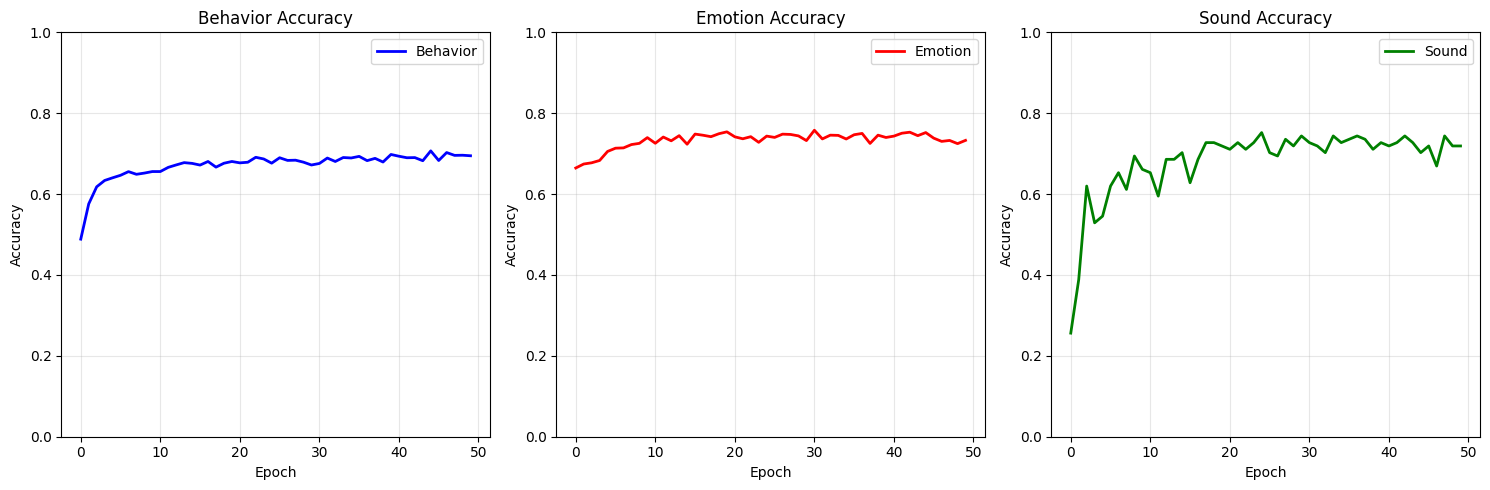

In [1]:
import os
import random
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torchvision.transforms as transforms
from torchvision.models import resnet34, ResNet34_Weights
from PIL import Image
import librosa
import numpy as np
from collections import defaultdict, Counter

# =========================
# 0. 설정
# =========================
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

BEHAVIOR_ROOT = "files/1_Animal_Behavior"
EMOTION_ROOT = "files/2_Animal_emotions"
SOUND_ROOT = "files/3_Animal_Sound"
WORK_DIR = "files/work/omni_dataset"

# 🔥 샘플 제한 설정
MAX_SAMPLES_BEHAVIOR = 100000  # Behavior 총 샘플 수
MAX_SAMPLES_EMOTION = 100000    # Emotion 총 샘플 수
# Sound는 데이터가 적으므로 전체 사용

BATCH_SIZE = 16
EPOCHS = 50
LR_VIDEO = 1e-4
LR_AUDIO = 1e-5
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 12
SR = 16000
MAX_AUDIO_LEN = SR * 5

LOSS_WEIGHTS = {
    "behavior": 1.0,
    "emotion": 0.8,
    "sound": 0.6
}

AUDIO_MODEL_NAME = "facebook/wav2vec2-base"
FEATURE_EXTRACTOR = Wav2Vec2FeatureExtractor.from_pretrained(AUDIO_MODEL_NAME)

print(f"🎯 Device: {DEVICE}")

# =========================
# 1. Dataset Preparation (개선)
# =========================
def collect_samples(root, exts):
    """모든 샘플 수집"""
    samples = []

    for class_dir in sorted(os.listdir(root)):
        class_path = os.path.join(root, class_dir)
        if not os.path.isdir(class_path):
            continue

        for root_dir, _, files in os.walk(class_path):
            for filename in files:
                if any(filename.lower().endswith(ext) for ext in exts):
                    file_path = os.path.join(root_dir, filename)
                    samples.append((class_dir, file_path))

    print(f"  → {len(samples)} samples, {len(set(s[0] for s in samples))} classes")
    return samples


def sample_balanced(samples, max_total_samples):
    """
    클래스별 균등 샘플링
    각 클래스당 max_samples_per_class = max_total_samples / num_classes
    """
    # 클래스별 그룹화
    class_samples = defaultdict(list)
    for label, path in samples:
        class_samples[label].append(path)
    
    num_classes = len(class_samples)
    max_per_class = max_total_samples // num_classes
    
    print(f"  🎯 Target: {max_total_samples} samples")
    print(f"  📊 {num_classes} classes → max {max_per_class} per class")
    
    # 클래스별 샘플링
    sampled = []
    for label, paths in class_samples.items():
        n_samples = min(len(paths), max_per_class)
        selected = random.sample(paths, n_samples)
        sampled.extend([(label, p) for p in selected])
        print(f"    {label}: {n_samples}/{len(paths)}")
    
    print(f"  ✅ Total sampled: {len(sampled)}")
    return sampled


def split_and_copy(samples, task_name):
    """8:1:1 split 후 복사"""
    random.shuffle(samples)
    class_samples = defaultdict(list)

    for label, path in samples:
        class_samples[label].append(path)

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(WORK_DIR, split, task_name), exist_ok=True)

    for label, paths in class_samples.items():
        n = len(paths)
        n_train = int(n * 0.8)
        n_val = int(n * 0.1)

        splits = {
            "train": paths[:n_train],
            "val": paths[n_train:n_train+n_val],
            "test": paths[n_train+n_val:]
        }

        for split_name, split_paths in splits.items():
            for src in tqdm(split_paths, desc=f"{task_name}/{split_name}/{label}", leave=False):
                dst_dir = os.path.join(WORK_DIR, split_name, task_name, label)
                os.makedirs(dst_dir, exist_ok=True)

                dst_path = os.path.join(
                    dst_dir,
                    f"{label}_{os.path.basename(src)}"
                )
                shutil.copy(src, dst_path)


def prepare_dataset():
    """데이터셋 준비 (샘플 제한 적용)"""
    if os.path.exists(WORK_DIR):
        shutil.rmtree(WORK_DIR)

    print("\n📦 Collecting behavior...")
    behavior_all = collect_samples(BEHAVIOR_ROOT, ['.jpg', '.png', '.jpeg'])
    behavior = sample_balanced(behavior_all, MAX_SAMPLES_BEHAVIOR)

    print("\n📦 Collecting emotion...")
    emotion_all = collect_samples(EMOTION_ROOT, ['.jpg', '.png', '.jpeg'])
    emotion = sample_balanced(emotion_all, MAX_SAMPLES_EMOTION)

    print("\n📦 Collecting sound...")
    sound = collect_samples(SOUND_ROOT, ['.wav', '.mp3', '.m4a'])
    print("  ℹ️  Sound: Using all samples (no limit)")

    print("\n📋 Splitting & Copying...")
    split_and_copy(behavior, "behavior")
    split_and_copy(emotion, "emotion")
    split_and_copy(sound, "sound")

    print("\n✅ Dataset ready")

# =========================
# 2. Dataset Classes
# =========================
class ImageDataset(Dataset):
    def __init__(self, task_dir, augment=False):
        self.samples = []
        self.label_to_id = {}

        for label in sorted(os.listdir(task_dir)):
            label_dir = os.path.join(task_dir, label)
            if not os.path.isdir(label_dir):
                continue

            self.label_to_id[label] = len(self.label_to_id)

            for file in os.listdir(label_dir):
                if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                    self.samples.append((os.path.join(label_dir, file), label))

        print(f"  📊 {os.path.basename(task_dir)}: {len(self.samples)} samples, {len(self.label_to_id)} classes")

        if augment:
            self.transform = transforms.Compose([
                transforms.Resize((256,256)),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(0.2, 0.2, 0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img, self.label_to_id[label]


class AudioDataset(Dataset):
    def __init__(self, task_dir):
        self.samples = []
        self.label_to_id = {}

        for label in sorted(os.listdir(task_dir)):
            label_dir = os.path.join(task_dir, label)
            if not os.path.isdir(label_dir):
                continue

            self.label_to_id[label] = len(self.label_to_id)

            for file in os.listdir(label_dir):
                if file.lower().endswith(('.wav','.mp3','.m4a')):
                    self.samples.append((os.path.join(label_dir,file), label))

        print(f"  📊 {os.path.basename(task_dir)}: {len(self.samples)} samples, {len(self.label_to_id)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        try:
            waveform, _ = librosa.load(path, sr=SR, mono=True)
        except:
            waveform = np.zeros(MAX_AUDIO_LEN)

        if len(waveform) > MAX_AUDIO_LEN:
            waveform = waveform[:MAX_AUDIO_LEN]
        else:
            waveform = np.pad(waveform,(0,MAX_AUDIO_LEN-len(waveform)))

        inputs = FEATURE_EXTRACTOR(waveform, sampling_rate=SR, return_tensors="pt")
        return inputs.input_values.squeeze(0), self.label_to_id[label]

# =========================
# 3. Models
# =========================
class VideoMultiBackbone(nn.Module):
    def __init__(self, num_b, num_e):
        super().__init__()

        # 🔵 Behavior Backbone
        backbone_b = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        self.behavior_backbone = nn.Sequential(*list(backbone_b.children())[:-1])
        self.behavior_head = nn.Linear(512, num_b)

        # 🔴 Emotion Backbone
        backbone_e = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        self.emotion_backbone = nn.Sequential(*list(backbone_e.children())[:-1])
        self.emotion_head = nn.Linear(512, num_e)

    def forward(self, x, task):

        if task == "behavior":
            feat = self.behavior_backbone(x)
            feat = feat.squeeze(-1).squeeze(-1)
            return self.behavior_head(feat)

        elif task == "emotion":
            feat = self.emotion_backbone(x)
            feat = feat.squeeze(-1).squeeze(-1)
            return self.emotion_head(feat)

        else:
            raise ValueError("Task must be 'behavior' or 'emotion'")

class AudioModel(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True):
        super().__init__()
        self.model = Wav2Vec2ForSequenceClassification.from_pretrained(
            AUDIO_MODEL_NAME,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

        if freeze_backbone:
            for param in self.model.wav2vec2.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.model(input_values=x).logits

# =========================
# 4. Training (진행 상황 추적 추가)
# =========================
def train():
    prepare_dataset()

    print("\n🔄 Loading datasets...")
    behavior_train = ImageDataset(os.path.join(WORK_DIR,"train","behavior"), augment=True)
    behavior_val = ImageDataset(os.path.join(WORK_DIR,"val","behavior"), augment=False)
    
    emotion_train = ImageDataset(os.path.join(WORK_DIR,"train","emotion"), augment=True)
    emotion_val = ImageDataset(os.path.join(WORK_DIR,"val","emotion"), augment=False)
    
    sound_train = AudioDataset(os.path.join(WORK_DIR,"train","sound"))
    sound_val = AudioDataset(os.path.join(WORK_DIR,"val","sound"))

    behavior_train_loader = DataLoader(behavior_train, BATCH_SIZE, True, num_workers=NUM_WORKERS, pin_memory=True)
    behavior_val_loader = DataLoader(behavior_val, BATCH_SIZE, False, num_workers=NUM_WORKERS//2, pin_memory=True)
    
    emotion_train_loader = DataLoader(emotion_train, BATCH_SIZE, True, num_workers=NUM_WORKERS, pin_memory=True)
    emotion_val_loader = DataLoader(emotion_val, BATCH_SIZE, False, num_workers=NUM_WORKERS//2, pin_memory=True)
    
    sound_train_loader = DataLoader(sound_train, BATCH_SIZE, True, num_workers=2, pin_memory=True)
    sound_val_loader = DataLoader(sound_val, BATCH_SIZE, False, num_workers=2, pin_memory=True)

    print(f"\n📦 DataLoaders:")
    print(f"  Behavior: {len(behavior_train_loader)} train batches, {len(behavior_val_loader)} val batches")
    print(f"  Emotion: {len(emotion_train_loader)} train batches, {len(emotion_val_loader)} val batches")
    print(f"  Sound: {len(sound_train_loader)} train batches, {len(sound_val_loader)} val batches")

    # 모델
    video_model = VideoMultiBackbone(
        len(behavior_train.label_to_id),
        len(emotion_train.label_to_id)
    ).to(DEVICE)


    audio_model = AudioModel(
        len(sound_train.label_to_id),
        # freeze_backbone=True
        freeze_backbone=False
    ).to(DEVICE)

    # Optimizer
    video_opt = torch.optim.AdamW(video_model.parameters(), lr=LR_VIDEO, weight_decay=0.01)
    audio_opt = torch.optim.AdamW(audio_model.parameters(), lr=LR_AUDIO, weight_decay=0.01)

    # Scaler
    video_scaler = torch.amp.GradScaler("cuda")
    audio_scaler = torch.amp.GradScaler("cuda")

    criterion = nn.CrossEntropyLoss()

    best_avg_acc = 0
    history = []

    for epoch in range(EPOCHS):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"{'='*60}")
        
        video_model.train()
        audio_model.train()

        # Task별 loss 누적
        loss_b_total, loss_e_total, loss_s_total = 0, 0, 0

        # -------- 1. Behavior --------
        print(f"\n🐾 Training Behavior...")
        for imgs, labels in tqdm(behavior_train_loader, desc="Behavior", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            with torch.amp.autocast("cuda"):
                logits = video_model(imgs, "behavior")
                loss = criterion(logits, labels) * LOSS_WEIGHTS["behavior"]

            video_opt.zero_grad()
            video_scaler.scale(loss).backward()
            video_scaler.step(video_opt)
            video_scaler.update()

            loss_b_total += loss.item()

        avg_loss_b = loss_b_total / len(behavior_train_loader)
        print(f"  → Avg Loss: {avg_loss_b:.4f}")

        # -------- 2. Emotion --------
        print(f"\n😊 Training Emotion...")
        for imgs, labels in tqdm(emotion_train_loader, desc="Emotion", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            with torch.amp.autocast("cuda"):
                logits = video_model(imgs, "emotion")
                loss = criterion(logits, labels) * LOSS_WEIGHTS["emotion"]

            video_opt.zero_grad()
            video_scaler.scale(loss).backward()
            video_scaler.step(video_opt)
            video_scaler.update()

            loss_e_total += loss.item()

        avg_loss_e = loss_e_total / len(emotion_train_loader)
        print(f"  → Avg Loss: {avg_loss_e:.4f}")

        # -------- 3. Sound --------
        print(f"\n🔊 Training Sound...")
        for audios, labels in tqdm(sound_train_loader, desc="Sound", leave=False):
            audios, labels = audios.to(DEVICE), labels.to(DEVICE)

            with torch.amp.autocast("cuda"):
                logits = audio_model(audios)
                loss = criterion(logits, labels) * LOSS_WEIGHTS["sound"]

            audio_opt.zero_grad()
            audio_scaler.scale(loss).backward()
            audio_scaler.step(audio_opt)
            audio_scaler.update()

            loss_s_total += loss.item()

        avg_loss_s = loss_s_total / len(sound_train_loader)
        print(f"  → Avg Loss: {avg_loss_s:.4f}")

        # -------- Validation --------
        print(f"\n🔍 Validation...")
        video_model.eval()
        audio_model.eval()

        # Behavior Val
        correct_b, total_b = 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(behavior_val_loader, desc="Val Behavior", leave=False):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                logits = video_model(imgs, "behavior")
                pred = logits.argmax(-1)
                correct_b += (pred == labels).sum().item()
                total_b += labels.size(0)
        acc_b = correct_b / total_b

        # Emotion Val
        correct_e, total_e = 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(emotion_val_loader, desc="Val Emotion", leave=False):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                logits = video_model(imgs, "emotion")
                pred = logits.argmax(-1)
                correct_e += (pred == labels).sum().item()
                total_e += labels.size(0)
        acc_e = correct_e / total_e

        # Sound Val
        correct_s, total_s = 0, 0
        with torch.no_grad():
            for audios, labels in tqdm(sound_val_loader, desc="Val Sound", leave=False):
                audios, labels = audios.to(DEVICE), labels.to(DEVICE)
                logits = audio_model(audios)
                pred = logits.argmax(-1)
                correct_s += (pred == labels).sum().item()
                total_s += labels.size(0)
        acc_s = correct_s / total_s

        avg_acc = (acc_b + acc_e + acc_s) / 3

        print(f"\n📊 Results:")
        print(f"  Behavior: Loss {avg_loss_b:.4f} | Acc {acc_b:.4f} ({acc_b*100:.1f}%)")
        print(f"  Emotion:  Loss {avg_loss_e:.4f} | Acc {acc_e:.4f} ({acc_e*100:.1f}%)")
        print(f"  Sound:    Loss {avg_loss_s:.4f} | Acc {acc_s:.4f} ({acc_s*100:.1f}%)")
        print(f"  Average Acc: {avg_acc:.4f} ({avg_acc*100:.1f}%)")

        # History 저장
        history.append({
            'epoch': epoch+1,
            'loss_b': avg_loss_b,
            'loss_e': avg_loss_e,
            'loss_s': avg_loss_s,
            'acc_b': acc_b,
            'acc_e': acc_e,
            'acc_s': acc_s,
            'acc_avg': avg_acc
        })

        # Best 모델 저장
        if avg_acc > best_avg_acc:
            best_avg_acc = avg_acc
            torch.save({
                "video_model": video_model.state_dict(),
                "audio_model": audio_model.state_dict(),
                "behavior_label_to_id": behavior_train.label_to_id,
                "emotion_label_to_id": emotion_train.label_to_id,
                "sound_label_to_id": sound_train.label_to_id,
                "best_epoch": epoch+1,
                "best_acc": best_avg_acc,
                "history": history
            }, "pet_omni_best.pth")
            print(f"  💾 Saved new best model! (Acc: {best_avg_acc:.4f})")

    # 그래프
    print("\n📈 Generating training history plot...")
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.plot([h['acc_b'] for h in history], 'b-', label='Behavior', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Behavior Accuracy'); plt.ylim(0, 1); plt.grid(True, alpha=0.3); plt.legend()

    plt.subplot(132)
    plt.plot([h['acc_e'] for h in history], 'r-', label='Emotion', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Emotion Accuracy'); plt.ylim(0, 1); plt.grid(True, alpha=0.3); plt.legend()

    plt.subplot(133)
    plt.plot([h['acc_s'] for h in history], 'g-', label='Sound', linewidth=2)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Sound Accuracy'); plt.ylim(0, 1); plt.grid(True, alpha=0.3); plt.legend()

    plt.tight_layout()
    plt.savefig('pet_omni_history.png', dpi=150, bbox_inches='tight')
    print("  ✅ Saved: pet_omni_history.png")

    print(f"\n🎉 Training Finished!")
    print(f"  Best Average Acc: {best_avg_acc:.4f} ({best_avg_acc*100:.1f}%)")


if __name__ == "__main__":
    train()

## Test

In [3]:
def test():

    print("🔎 Loading best model...")
    checkpoint = torch.load("pet_omni_best.pth", map_location=DEVICE)

    behavior_label_to_id = checkpoint["behavior_label_to_id"]
    emotion_label_to_id = checkpoint["emotion_label_to_id"]
    sound_label_to_id = checkpoint["sound_label_to_id"]

    video_model = VideoMultiBackbone(
        len(behavior_label_to_id),
        len(emotion_label_to_id)
    ).to(DEVICE)

    audio_model = AudioModel(
        len(sound_label_to_id)
    ).to(DEVICE)

    video_model.load_state_dict(checkpoint["video_model"])
    audio_model.load_state_dict(checkpoint["audio_model"])

    video_model.eval()
    audio_model.eval()

    print("📦 Loading TEST datasets...")

    behavior_test = ImageDataset(os.path.join(WORK_DIR,"test","behavior"))
    emotion_test = ImageDataset(os.path.join(WORK_DIR,"test","emotion"))
    sound_test = AudioDataset(os.path.join(WORK_DIR,"test","sound"))

    behavior_loader = DataLoader(behavior_test, BATCH_SIZE, False)
    emotion_loader = DataLoader(emotion_test, BATCH_SIZE, False)
    sound_loader = DataLoader(sound_test, BATCH_SIZE, False)

    # -------- Behavior --------
    correct_b, total_b = 0, 0
    with torch.no_grad():
        for imgs, labels in behavior_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = video_model(imgs, "behavior")
            pred = logits.argmax(-1)
            correct_b += (pred == labels).sum().item()
            total_b += labels.size(0)

    acc_b = correct_b / total_b

    # -------- Emotion --------
    correct_e, total_e = 0, 0
    with torch.no_grad():
        for imgs, labels in emotion_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = video_model(imgs, "emotion")
            pred = logits.argmax(-1)
            correct_e += (pred == labels).sum().item()
            total_e += labels.size(0)

    acc_e = correct_e / total_e

    # -------- Sound --------
    correct_s, total_s = 0, 0
    with torch.no_grad():
        for audios, labels in sound_loader:
            audios, labels = audios.to(DEVICE), labels.to(DEVICE)
            logits = audio_model(audios)
            pred = logits.argmax(-1)
            correct_s += (pred == labels).sum().item()
            total_s += labels.size(0)

    acc_s = correct_s / total_s

    avg_acc = (acc_b + acc_e + acc_s) / 3

    print("\n📊 TEST Results:")
    print(f"  Behavior Acc: {acc_b:.4f} ({acc_b*100:.1f}%)")
    print(f"  Emotion Acc:  {acc_e:.4f} ({acc_e*100:.1f}%)")
    print(f"  Sound Acc:    {acc_s:.4f} ({acc_s*100:.1f}%)")
    print(f"  Average Acc:  {avg_acc:.4f} ({avg_acc*100:.1f}%)")

if __name__ == "__main__":
    test()

🔎 Loading best model...


Loading weights: 100%|██████████| 211/211 [00:00<00:00, 440.03it/s, Materializing param=wav2vec2.masked_spec_embed]                                            
Wav2Vec2ForSequenceClassification LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     | 
-----------------------------+------------+-
project_q.weight             | UNEXPECTED | 
project_hid.bias             | UNEXPECTED | 
quantizer.codevectors        | UNEXPECTED | 
quantizer.weight_proj.bias   | UNEXPECTED | 
quantizer.weight_proj.weight | UNEXPECTED | 
project_q.bias               | UNEXPECTED | 
project_hid.weight           | UNEXPECTED | 
projector.bias               | MISSING    | 
classifier.bias              | MISSING    | 
projector.weight             | MISSING    | 
classifier.weight            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because miss

📦 Loading TEST datasets...
  📊 behavior: 5314 samples, 25 classes
  📊 emotion: 5604 samples, 10 classes
  📊 sound: 132 samples, 16 classes

📊 TEST Results:
  Behavior Acc: 0.6927 (69.3%)
  Emotion Acc:  0.7589 (75.9%)
  Sound Acc:    0.7727 (77.3%)
  Average Acc:  0.7414 (74.1%)
